Presentado por: Diego Quisi


# Entornos de soporte al desarrollo de simulaciones: Simpy - Parte 1

## 1. Instalación de Simpy
Existen diversas alternativas para instalar **simpy** (no confundir con _sympy_), sin embargo, en esta subsección mostraremos cómo hacerlo.


### 1.1. Pasos a seguir:
En virtud de que **simpy** requiere la versión 3.7 de Python, llevaremos a cabo el proceso para instalar dicha versión:
1. Creamos el entorno virtual llamado "simulacion" con la versión 3.7 de Python:

        conda activate
        
2. Installamos **simpy**  en el entorno creado:
        pip3 install -U simpy
        


Si la instalación ha sido exitosa, podremos ejecutar el siguiente código sin inconvenientes:

In [2]:
import simpy

# Definimos un reloj:
def reloj(env, nombre, tiempo):
    while True:
        print(nombre,">",env.now) 
        yield env.timeout(tiempo) # Pasamos el control al programa principal
        
env=simpy.Environment() # Creamos un entorno de simulación
env.process(reloj(env, 'R. Rapido',0.25)) # Ejecutamos un "reloj" rapido (timer) en el entorno con el tiempo especificado
env.process(reloj(env, 'R. Lento',0.5)) # Ejecutamos un "reloj" lento (timer) en el entorno con el tiempo especificado

env.run(until=2.1) # Ejecutamos los procesos 2 unidades de tiempo

R. Rapido > 0
R. Lento > 0
R. Rapido > 0.25
R. Lento > 0.5
R. Rapido > 0.5
R. Rapido > 0.75
R. Lento > 1.0
R. Rapido > 1.0
R. Rapido > 1.25
R. Lento > 1.5
R. Rapido > 1.5
R. Rapido > 1.75
R. Lento > 2.0
R. Rapido > 2.0


## 2. Ejemplo del negocio de lavado de autos [5]

Este ejemplo permite simular un negocio de lavado de automóviles. De igual forma, es importante destacar que este ejemplo aborda los siguientes puntos:

* Estados de espera por otros procesos
* Recursos: clase **Resource**


### 2.1. Características del sistema real a simular

Es importante observar que el negocio de lavado de autos tiene características propias a su naturaleza. A continuación establecemos dichas peculiaridades a tener en mente en el momento de llevar a cabo la simulación:

* El negocio tiene un número limitado de máquinas de lavado.
* Se puede recibir un cierto número de vehículos para ser lavados, de los cuáles los que no estén siendo procesados tendrán que esperar.
* Una vez que un vehículo entra a la máquina, debe ser lavado y solo al finalizar la limpieza podrá salir de la misma, dejando un espacio libre a otro vehículo.

### 2.2. Desarrollo de la simulación

A continuación procedemos a desarrollar la simulación.

Como primer paso, importamos las librerías necesarias y establecemos los parámetros requeridos:
* Variables de interés
* Tiempo de simulación
* Parámetros de inicialización (número de máquinas, tiempo de lavado, intervalo de llegada de vehículos).

In [3]:
import simpy
import random

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 23

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice
        yield self.env.timeout(TIEMPO_LAVADO)
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' \
              % (random.randint(30,90), vehiculo))
        
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))
    
    
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),lavanderia))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2)) # Generar un randomico de 7 - 11 
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),lavanderia))

print('Lavanderia UPS')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)


Lavanderia UPS
Llega vehiculo: Vehiculo-1 a la hora 0.00.
Llega vehiculo: Vehiculo-2 a la hora 0.00.
Llega vehiculo: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-4 a la hora 0.00.
Llega vehiculo: Vehiculo-5 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-1 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-2 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-6 a la hora 7.00.
Removido  {33%} suciedad vehiculo => Vehiculo-1 
Removido  {89%} suciedad vehiculo => Vehiculo-2 
Removido  {87%} suciedad vehiculo => Vehiculo-3 
Vehiculo [Vehiculo-1] lavado a las 7.00.
Vehiculo [Vehiculo-2] lavado a las 7.00.
Vehiculo [Vehiculo-3] lavado a las 7.00.
Entra vehiculo a lavarse: Vehiculo-4 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-5 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-6 a la hora 7.00.
Removido  {64%} suciedad vehiculo => Vehiculo-4 
Removido  {57%} suciedad vehiculo => Vehiculo-5 
Removido  {72%} suciedad vehiculo => Vehi

## Práctica  - SimPy 

- Investigar el proceso de atencion de un paciente diagnosticado con COVID-19, ademas de tiempos de atencion, recursos necesarios y tipos de pacientes.
- Investigar en cada una de las provincias asignadas el numero de hospitales, camas, respiradores y personal medico, limpieza y enfermeria.
- Finalmente el costo de atender a un paciente con COVID-19 y medicamentos.


## - Investigar el proceso de atencion de un paciente diagnosticado con COVID-19, ademas de tiempos de atencion, recursos necesarios y tipos de pacientes.
La Agencia de Salud Pública de Canadá está trabajando con provincias, territorios y socios internacionales, incluida la Organización Mundial de la Salud, para monitorear activamente la situación. Los esfuerzos mundiales se centran en la contención del brote y la prevención de una mayor propagación.algunas de las respuestas son
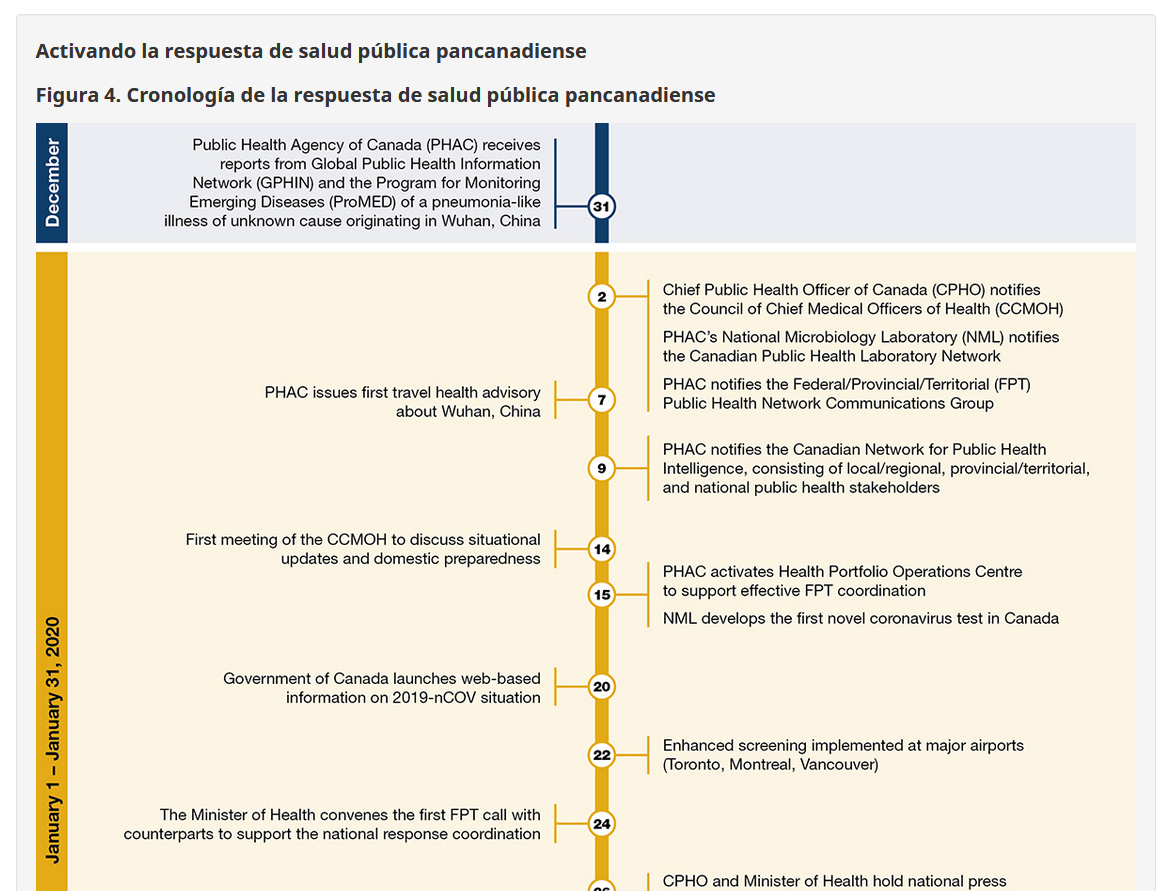


## - Investigar en cada una de las provincias asignadas el numero de hospitales, camas, respiradores y personal medico, limpieza y enfermeria.
en el caso de canada  la enfermedad sigue siendo difícil de tratar, los equipos de cuidados intensivos que tratan a los pacientes más enfermos se sienten mejor equipados para salvar más vidas,cuenta con 2,5 camas por por cada 1.000 personas. Enlo que respecta a otros insumo cuenta conlos nesesarios para surtir la demanda .el principal problema de este pais es la distancia que existe entrelos abiantes  donde la densidad demográfica en el país norteamericano es de 3. 92 habitantes por kilómetro cuadrado.esto inpide el tratamiento pronto dela enfermedad.
Acontinuacion se detalla el indise de infectados  a dia de  hoy:

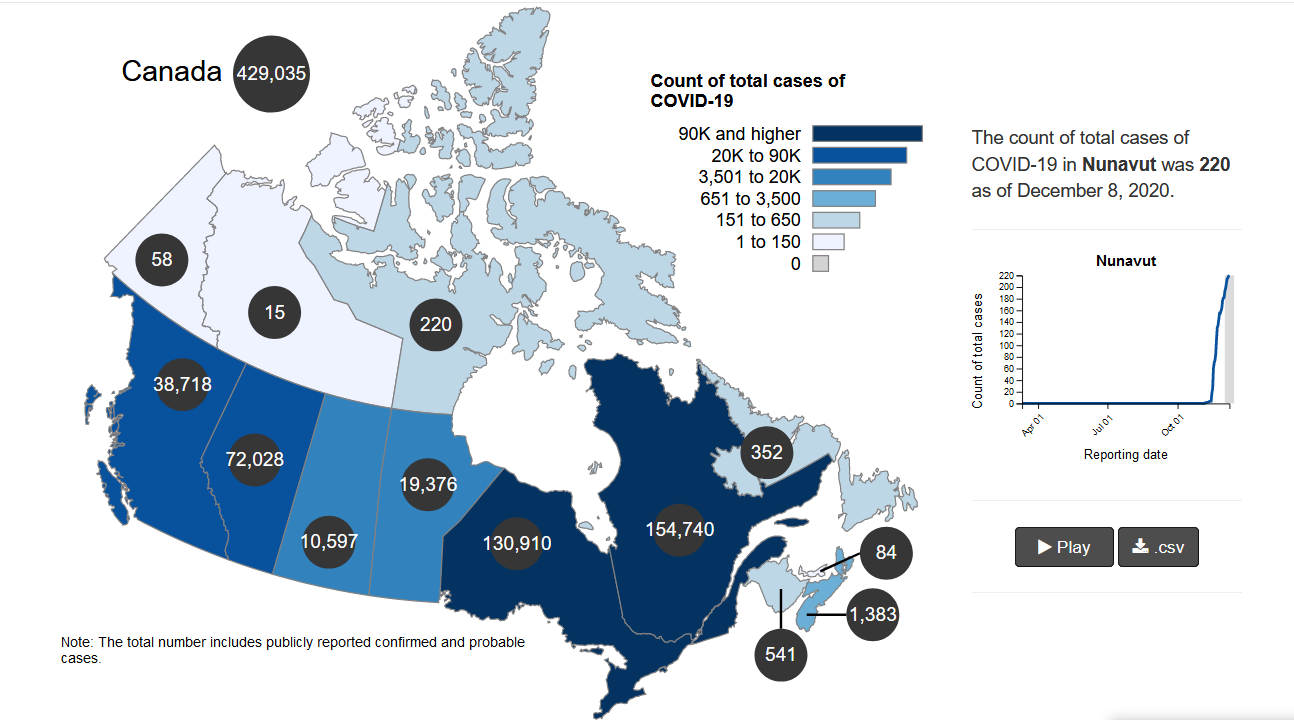

## - Finalmente el costo de atender a un paciente con COVID-19 y medicamentos.
A continuacion se detalla el gasto del gobierno referente al cobit:
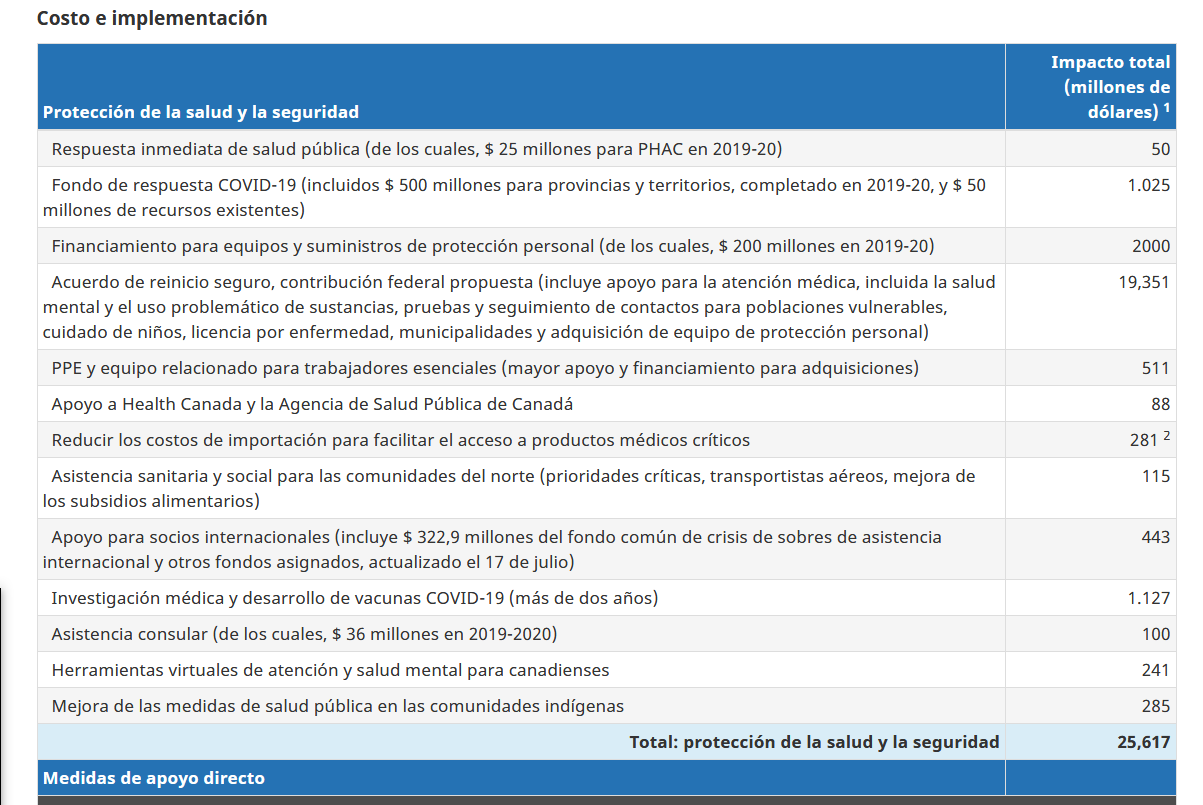



## Referencias
[1] Matloff, N. (2008). Introduction to Discrete-Event Simulation and the SimPy Language.

[2] Team Simpy (2017). SimPy Documentation, Release 3.0.10, 2017. URL: https://media.readthedocs.org/pdf/simpy/latest/simpy.pdf 

[3] https://www.alainet.org/es/articulo/205892

[4] https://lenhrbqfmm3e7o3klqaeamo4yi--www-canada-ca.translate.goog/en/public-health/corporate/publications/chief-public-health-officer-reports-state-public-health-canada/from-risk-resilience-equity-approach-covid-19.html#a1.3

[5]https://www.rcinet.ca/es/2020/07/27/los-hospitales-canadienses-estan-mejor-preparados-ante-el-covid-19/